# POWERLIFTING!

Hi All!

This has been my first foray into an end to end Data Analysis project. I picked this dataset as I knew little to nothing about Powerlfting and would need to rely more on my analysis of the data than my outside knowledge. It also seemed liked an interesting topic I could learn more about. After breiefly looking at the different columns within the data I wanted to see if it would be possible to predict weather a person was predicted to win first place or not.

## 1. The Basics
     a. Import Libraries and Data
     b. Combine Data Tables
     c. Split Data
## 3. Data Cleaning & Feature Engineering
## 4. EDA
## 5. 

# 1. Importing Libraries and Data

As with any project we need to import the standard libraries. In this case our data came from 2 files. Typically if these were larger we would analyze them sepertley first. However, each was small enough that combining them before starting further analysis was simple enough and would not make our dataset too large to start.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import os
print(os.listdir())

['.ipynb_checkpoints', 'kernel.ipynb']


In [2]:
meet = pd.read_csv("../data/meets.csv")
power = pd.read_csv("../data/openpowerlifting.csv")

**After importing our tables and turning them into Pandas Dataframes, we want to see the basic information on each table. The best option is to join the tables before moving on to further analysis if possible. Here, the "MeetID" column is a perfect candidate to join our table using pd.merge.**

In [3]:
strong = meet.merge(power,
                  on = "MeetID", 
                   how = 'left')

# This merges the two tables we have. This performs a "Left Join - this keeps all information in the "left" table and includes any data from the "Right" table that matches on the criterea "MeetID".

Before moving any further we will want to split our data into a train and test split in case we want to eventually do machine learning and test our algorithm.

A key item to note here is to make sure that our train and test samples both have the same number of features so they can be accuratley trained and evaluated using a model.

In [4]:
from sklearn.model_selection import train_test_split                                # To start we import the train_test_split functionality from sklearn model selection.
def train_test_official(df):                                                        # We create a function that spllits our data into a train/test split using the standard 20%. This is purley random splitting of
    train_set, test_set = train_test_split(df, test_size = .2)                      # our data for now. If after further investigation we learn we need to use a stratified sampling technique we can adjust this function.
    return train_set, test_set
train_set, test_set = train_test_official(strong)

df = train_set

print("The training data has {} rows.".format(train_set.shape[0]))                  # This output shows how many rows the train and test split has. More importantly it confirms that we have the same number of features
print("The test data has {} rows.".format(test_set.shape[0]))                       # in the train and test data which will be important for some of our Machine Learning Algorithms in the future.
print("Both have {} features" .format(train_set.shape[1]))
print("Both have {} features" .format(test_set.shape[1]))
# Very convoluted but helps reinfroce what gets returned from a function and what does not.

The training data has 309131 rows.
The test data has 77283 rows.
Both have 24 features
Both have 24 features


# 3. Data Cleaning & Featurization.

Since "Place" is our target variable, we wll start by cleaning up this column before moving on to the rest of the data.

In [5]:
print(df['Place'].describe())                                                             # Gives us the basic summary statistics of this column.
print("\n")
print("There are a few missing values..." + str(df['Place'].isnull().sum()))              # We use the isnull and sum function in order to see all the missing values in this column.
df['Place'].value_counts().iloc[3:4]                                                      # After organizing the data by using "Value_counts" we can locate the index where the sum of the labels for "DQ" is listed.

count     308235
unique        81
top            1
freq      155859
Name: Place, dtype: object


There are a few missing values...896


DQ    18421
Name: Place, dtype: int64

Looking at our data it appears not all values are numeric! There are some strings that will cause errors when we try to plot the data. And this is only from 1 variable!

In addition, looking at the data shows we have 2 problems. First, we have the "DQ" value which will not work with anything we will be doing. We can convert this to another value or replace with Naan. Second, our dataset is currently a classification problem between 81 different positions! While possible, this will make it difficult for our algorithm to pinpoint something particularyly helpful for us. We will need to review this more thoroughly.

To alleviate this we are going to turn this into a binary clasasification problem and only focus on predicting 1st place (2nd place is just the first loser). This helps solve both of these problems. We can treat the "DQ" as any other "Not First" position.

In [6]:
def convert_place(x):
    x['Place'] = x['Place'] == "1"    # Converts any value in the column that is = 1 (First Place) into the boolean "True", anything else (including strings or other numbers) to "False"

In [7]:
df["Place"].value_counts().head(5)

1     155859
2      45819
3      23866
DQ     18421
4      15276
Name: Place, dtype: int64

In [8]:
convert_place(df)
df["Place"].value_counts().head(5)

True     155859
False    153272
Name: Place, dtype: int64

Lets look at a complete heatmap of our data for missing values. We will do so with a table of percent missing items and a heatmap showing this.

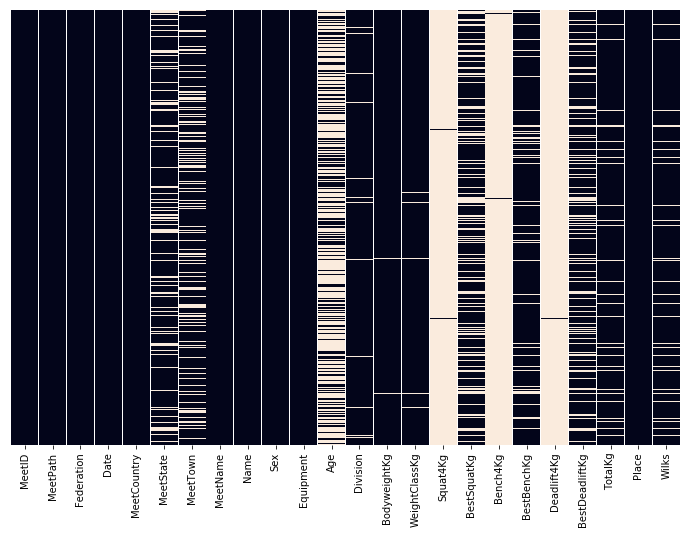

In [9]:
plt.figure(figsize=(12,8))                                                                 # First we initialize a figure with the right size for our plot.
sns.heatmap(data = df.isnull(),cbar=False,yticklabels=False)            # Then plot our chart. We remove the colorbar and the y axis as they are not needed to see where we have missing values.

In [30]:
def missing_val(df):
    Total = df.isnull().sum()
    Percent = (Total / len(df))*100
    Table = pd.concat([Total, Percent], axis = 1)
    Table = Table.rename(columns = {0: "Total Missing", 1: "Percent Missing"})
    print(Table)

In [31]:
missing_val(df)

                Total Missing  Percent Missing
MeetID                      0         0.000000
MeetPath                    0         0.000000
Federation                  0         0.000000
Date                        0         0.000000
MeetCountry                 0         0.000000
MeetState               57683        18.659727
MeetTown                75115        24.298760
MeetName                    0         0.000000
Name                        0         0.000000
Sex                         0         0.000000
Equipment                   0         0.000000
Age                    191504        61.949141
Division                12678         4.101174
BodyweightKg             1890         0.611391
WeightClassKg            3028         0.979520
Squat4Kg               308119        99.672631
BestSquatKg             70776        22.895148
Bench4Kg               307559        99.491478
BestBenchKg             24163         7.816427
Deadlift4Kg            306827        99.254685
BestDeadliftK

We will need to look at each of these columns in order to determine how to deal with the missing values. All the 4KG columns will be deleted as they have barley any rows of viable data. While going through this we should determine if new columns can be created in order to supplement whatever missing data we will have.

In [ ]:
train_set.drop(["Squat4Kg","Bench4Kg", "Deadlift4Kg"], axis = 1)
test_set.drop(["Squat4Kg","Bench4Kg", "Deadlift4Kg"], axis = 1)
df.drop(["Squat4Kg","Bench4Kg", "Deadlift4Kg"], axis = 1)

In [ ]:
plt.figure(figsize=(12,8))                                                                 # First we initialize a figure with the right size for our plot.
sns.heatmap(data = df.isnull(),cbar=False,yticklabels=False,)            # Then plot our chart. We remove the colorbar and the y axis as they are not needed to see where we have missing values.

In [ ]:
df.sum()

In [ ]:
def correlation(df):
    cor = df.corr()
    plt.subplots(figsize=(10,5))
    sns.heatmap(data = cor,
               annot = True,
               center = 0,
               cmap="coolwarm")
    
correlation(df)

In [ ]:
strong.head(2)

In [ ]:
x = strong["MeetCountry"].value_counts().index.tolist()[:11]
y = []
for item in x:
    y.append(strong["MeetCountry"].value_counts()[item])

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x = x,
            y = y, data = power)
plt.xticks(rotation=90)

The United States is by far the largest for wieghtlifting competitions. Lets see where in the U.S. these are.

In [ ]:
fig = plt.figure()

states = strong[strong["MeetCountry"] == "USA"]

x = states["MeetTown"].value_counts().index.values[:11]
y = states["MeetTown"].value_counts().values[:11]

plt.figure(figsize = (10,6))
sns.barplot(x,y)

Vegas Baby!

Next let's breakdown who is competing, their gender, weight, and equipment.

In [ ]:
f, axs = plt.subplots(2,1,figsize=(12,8))

plt.subplot (2,1,1)
sns.countplot(strong['Equipment'], palette = 'Set1', hue = strong['Sex'])
plt.subplot (2,1,2)
sns.countplot(strong['Sex'], palette = 'Set1')

Raw powerlifting means lifting without any added equipment.
Single-ply and Multi-ply are a type of equipment worn meant to aid a lifter. More ply = More Assistance.
Wraps and Straps are typically worn on the hands or around the knees to enhance grip and saftey.

More than 2 times the number of men compete than woman.

In [ ]:
#f, axe = plt.subplots(1,2,figsize = (12,8))
sns.jointplot(x =strong['Age'].where(strong['Sex'] == "M"),
             y = strong['BodyweightKg'],
             data = strong, color = "g")

sns.jointplot(x =strong['Age'].where(strong['Sex'] == "F"),
             y = strong['BodyweightKg'],
             data = strong)

In [ ]:
sns.lmplot(x =strong['Age'],
             y = strong['BodyweightKg'],
             data = strong)

In [ ]:
# A failed thought process led me to this. Helpful for me to remembr .loc vs .iloc.

type(df['Place'].loc[df['Place'] == "DQ"].iloc[0]) # Confirm that the "DQ" value we see is a string. We do this by using .loc to return a series of all "DQ" values. Then we use .iloc to return
                                                   # the first value of that series. Then we check the type.